In [1]:
import logging

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [3]:
dtype = tf.dtypes.float32

In [4]:
N = 100
p = 3
beta_dist = tfd.Uniform(-10, 10)
tf.random.set_seed(0)
beta = beta_dist.sample((p, 1), seed=1)
sigma_squared = tf.constant(1.0, dtype=dtype)
print((N, p))
print(beta)
print(sigma_squared)

(100, 3)
tf.Tensor(
[[ 0.79460335]
 [-7.901206  ]
 [-5.9763646 ]], shape=(3, 1), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [5]:
X_dist = tfd.Uniform(low=-1.0, high=1.0)
error_dist = tfd.Normal(loc=0, scale=sigma_squared ** 0.5)
tf.random.set_seed(0)
X = X_dist.sample((N, p), seed=0, name="X")
error = error_dist.sample((N, 1), seed=0, name="error")
y = X @ beta + error

In [6]:
beta_hat_ols = tf.linalg.inv(tf.transpose(X) @ X) @ tf.transpose(X) @ y
beta_hat_ols

<tf.Tensor: id=87, shape=(3, 1), dtype=float32, numpy=
array([[ 1.1683835],
       [-8.062305 ],
       [-6.1278896]], dtype=float32)>

In [7]:
class Regression(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def rss(self, beta_hat):
        residuals = self.y - self.X @ beta_hat
        square_residuals = tf.transpose(residuals) @ residuals
        rss = tf.reduce_sum(square_residuals)
        return rss

    def dist(self, theta_hat):
        N, p = self.X.shape
        beta_hat = theta_hat[0:p][..., tf.newaxis]
        sigma_squared = theta_hat[p]
        mu = self.X @ beta_hat
        scale = sigma_squared ** 0.5
        return tfd.Normal(mu, scale)

    def likelihood(self, theta_hat):
        dist = self.dist(theta_hat)
        probs = dist.prob(y)
        return tf.reduce_prod(probs)

    def neg_log_likelihood(self, theta_hat):
        dist = self.dist(theta_hat)
        log_probs = dist.log_prob(y)
        return -1 * tf.reduce_sum(log_probs)


In [8]:
regression = Regression(X, y)

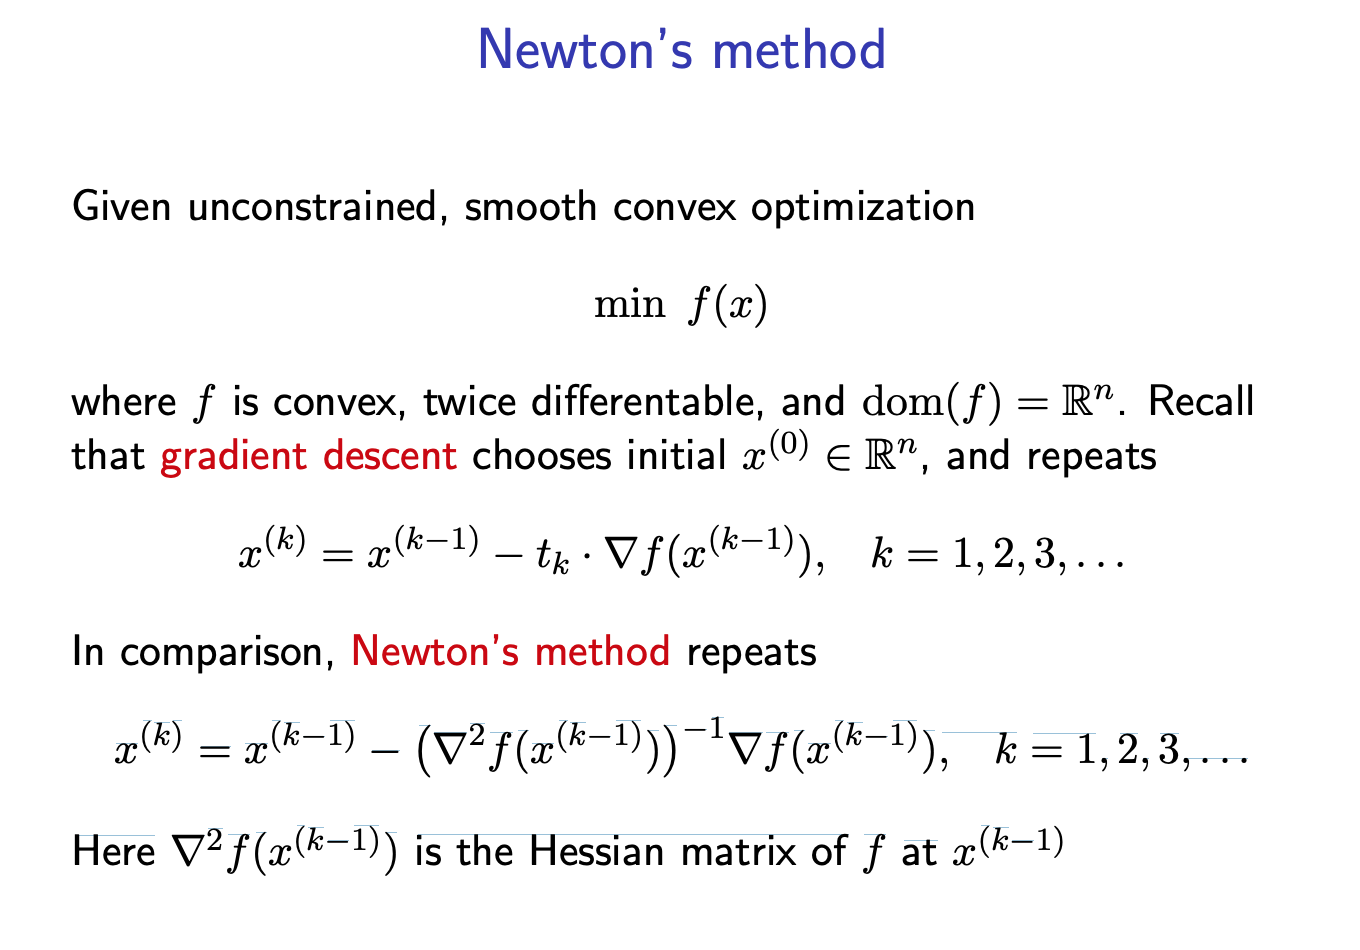

In [10]:
def newton_raphson_direction(f, x):
    with tf.GradientTape(persistent=True) as tape:
        f_x = f(x)
        grad = tape.gradient(f_x, x)
    hessian = tape.jacobian(grad, x)
    hessian_inv = tf.linalg.inv(hessian)
    direction = tf.linalg.matvec(hessian_inv, grad)
    return direction


def newton_raphson_one_step(f, x_value, step_size):
    f_x_old = f(x_value)
    x = tf.Variable(x_value)
    direction = newton_raphson_direction(f, x)
    x_new = x + step_size * tf.math.l2_normalize(direction)
    f_x_new = f(x_new)
    print(x_new.numpy())
    print(f_x_new.numpy())
    print(abs(f_x_new - f_x_old))
    return x_new


def minimize_f_newton_raphson(f, initial_x, ftol, step_size):
    x_old = initial_x
    x = newton_raphson_one_step(f, x_old, step_size)
    while abs(f(x_old) - f(x)) > ftol:
        x_old = x
        x = newton_raphson_one_step(f, x_old, step_size)
    return x


## Convergence is not working

Something is happening with `sigma_squared`.

Seeded randomly, the optimization path stagnates around `[2.0911572, -1.2336255, -0.13150322, 2.0253892]`.

In [ ]:
# x_start = (tf.random.uniform(shape=(p + 1,)) + 1) * 2
x_start = tf.constant([2.0911572, -1.2336255, -0.13150322, 2.0253892])

minimize_f_newton_raphson(
    regression.neg_log_likelihood,
    x_start,
    0.1,
    0.01
)

Starting at the OLS point for beta, the optimization path is stable for beta but _worsens_ for `sigma_squared`. 

In [11]:
beta_hat_ols[..., 0]

<tf.Tensor: id=96110, shape=(3,), dtype=float32, numpy=array([ 1.1683835, -8.062305 , -6.1278896], dtype=float32)>

In [14]:
# x_start = (tf.random.uniform(shape=(p + 1,)) + 1) * 2
x_start = tf.constant([ 1.1683835, -8.062305 , -6.1278896, 1.5])

minimize_f_newton_raphson(
    regression.neg_log_likelihood,
    x_start,
    0.1,
    0.01
)

[ 1.1683835 -8.062305  -6.1278896  1.51     ]
146.55028
tf.Tensor(0.10523987, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.52     ]
146.65627
tf.Tensor(0.10598755, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.53     ]
146.76306
tf.Tensor(0.106796265, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.54     ]
146.87057
tf.Tensor(0.10751343, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.55     ]
146.97882
tf.Tensor(0.10824585, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.56     ]
147.08769
tf.Tensor(0.10887146, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.5699999]
147.19725
tf.Tensor(0.109558105, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.5799999]
147.30742
tf.Tensor(0.11016846, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.5899999]
147.41823
tf.Tensor(0.110809326, shape=(), dtype=float32)
[ 1.1683835 -8.062305  -6.1278896  1.5999999]
147.5296
tf.Tensor(0.111

KeyboardInterrupt: 

In [ ]:
x = tf.Variable((tf.random.uniform(shape=(p+1,)) + 1)* 2)

with tf.GradientTape(persistent=True) as tape:
    l = regression.neg_log_likelihood(x)
    grad_l = tape.gradient(l, x)
hessian_l = tape.jacobian(grad_l, x)
hessian_l_inv = tf.linalg.inv(hessian_l)
update = tf.linalg.matvec(hessian_l_inv, grad_l)
new_x = x + 0.0001 * update

for tensor in [
    x,
    x[0:p] - beta_hat_ols[:, 0],
    l,
    grad_l,
    hessian_l,
    hessian_l_inv,
    update,
    new_x,
    regression.neg_log_likelihood(new_x),
]:
    print(tensor)
# print(x.numpy())
# print(l)
# print(grad_l)
# print(hessian_l)
# print(hessian_l_inv)
# print(update)

# tf.linalg.matvec(l_hessian_inv, l_prime)

In [ ]:
beta, sigma_squared

# Less important stuff

In [ ]:
print("RSS of the truth!")
regression.rss(beta).numpy()

In [ ]:
beta_hat = tf.Variable(tf.zeros(shape=(p, 1)), name="beta_hat")

with tf.GradientTape() as t:
    rss = regression.rss(beta_hat)
rss_grad = t.gradient(rss, beta_hat)

print(rss)
print(rss_grad)

In [ ]:
value = tf.zeros(shape=(p,1))
# value = tf.constant(beta_hat_ols)
beta_hat = tf.Variable(value, name="beta_hat")

with tf.GradientTape(persistent=True) as tape:
    rss = regression.rss(beta_hat)
    rss_grad = tape.gradient(rss, beta_hat)
rss_hessian = tape.jacobian(rss_grad, beta_hat)

print(rss)
print(rss_grad)
print(rss_hessian[..., 0])

And this should equal...

In [ ]:
2 * tf.transpose(X) @ X

what about likelihood?

In [ ]:
beta_hat_ols

https://github.com/tensorflow/tensorflow/issues/29781#issuecomment-504980912

In [ ]:
beta_var = tf.Variable(beta_hat)
theta_var = tf.Variable(tf.random.normal((p+1,)))
theta_var

In [ ]:
def compute_hessian(f, x):
    with tf.GradientTape(persistent=True) as tape:
        print(f)
        print(x)
        target = f(x)
        print(target)
        grad = tape.gradient(target, x)
        print(grad)
    hessian = tape.jacobian(grad, x)
    return hessian

print(compute_hessian(regression.rss, beta_var)[0:p, 0, 0:p, 0])
# print(compute_hessian(regression.likelihood, theta_var))
print(compute_hessian(regression.neg_log_likelihood, theta_var))

# Plotting!

In [ ]:
import plotly.graph_objects as go

import pandas as pd

z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

In [ ]:
fig = go.Figure(data=[go.Surface(z=z_data.values)])
fig.update_traces(contours_z=dict(
    show=True,
    usecolormap=True,
    highlightcolor="limegreen",
    project_z=True))


### Old hessian stuff, before i used the jacobian

In [ ]:
def compute_hessian(f, x):
    with tf.GradientTape(persistent=True) as hess_tape:
        with tf.GradientTape() as grad_tape:
            target = f(x)
            print(target)
            print(tf.math.log(target))
        grad = grad_tape.gradient(target, x) / target
        print(grad)
        grad_grads = [hess_tape.gradient(g, x)[..., tf.newaxis] for g in grad]
    hessian = tf.concat(grad_grads, axis=1)
    return hessian

# print(rss_grad_grads)
# print(rss_hess_rows)
print(compute_hessian(regression.likelihood, theta_hat))
print(compute_hessian(regression.neg_log_likelihood, theta_hat))

### Figuring out the distribution API../

In [ ]:
N = 100
p = 3
beta_dist = tfd.Uniform(-10, 10)
tf.random.set_seed(0)
beta = beta_dist.sample((p, 1), seed=1)
sigma_squared = tf.constant(1.0, dtype=dtype)
print((N, p))
print(beta)
print(sigma_squared)

In [ ]:
X_dist = tfd.Uniform(low=-1.0, high=1.0)
error_dist = tfd.Normal(loc=0, scale=sigma_squared ** 0.5)
tf.random.set_seed(0)
X = X_dist.sample((N, p), seed=0, name="X")
error = error_dist.sample((N, 1), seed=0, name="error")
y = X @ beta + error

In [ ]:
# regression.likelihood()


N, p = X.shape
beta_hat = tf.ones((p, 1), dtype=dtype)
beta_hat = tf.constant(beta_hat_ols)
print(beta_hat)
sigma_squared = tf.constant(1.0)
print(sigma_squared)
mu = X @ beta_hat
print(mu.shape)
print(y.shape)


# norm = tfd.Normal(loc=mu, scale=sigma_squared ** 0.5)
# print(norm)
# probs = norm.prob(y)
# print(probs)

scale_diag = tf.ones(shape=(N,1), dtype=dtype) * sigma_squared ** 0.5
mvn = tfd.MultivariateNormalDiag(loc=mu, scale_diag=scale_diag)
probs = mvn.prob(y)
print(probs)
likelihood = tf.reduce_prod(probs)
print(likelihood)

log_probs = mvn.prob(y)
print(log_probs)
neg_log_likelihood = -1 * tf.reduce_sum(log_probs)
print(neg_log_likelihood)
